# Imports

In [2]:
#!pip install tf2onnx
import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
from scipy.stats import qmc
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib #to save Scalers
from sklearn.metrics import mean_squared_error
import seaborn as sns
from keras.models import Sequential, Model
from keras import Input
from keras.layers import Dense, Conv1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback
from keras import Loss
from keras.saving import register_keras_serializable
from keras.utils import split_dataset
import keras
import tf2onnx
from src._utils.utils import load_yaml_file

PHYSICS_PARAMS = load_yaml_file("src/config.yml")["PHYSICS_PARAMS"]

## Helper funcs

In [44]:
def comparison_plot(dt, true_data: np.ndarray,
                     pred_data: list[tuple[np.ndarray, str]], suptitle: str,
                     meas_data: np.ndarray = None):
    '''
    true_data: contains acc, vel (in m/s), and pos in (t, 3) shape
    '''
    data, label = pred_data[0]
    t_end = (data.shape[0]-1)*dt
    t = np.arange(0, t_end+dt, dt)
    
    # Plot for acceleration:
    plt.figure()
    plt.plot(t, true_data[:, 0], label="True Acceleration", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 0], '--', label=label, linewidth=2)
    if meas_data is not None:
        plt.scatter(t, meas_data, label="Measured acceleration points", s=7, c='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Acceleration")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot for velocity:
    plt.figure()
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2) #conversion from m/s to km/h
    for data, label in pred_data:
        plt.plot(t, data[:, 1]*3.6, '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot for position
    plt.figure()
    plt.plot(t, true_data[:, 2], label="True Position", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 2], '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history, es_start_epoch):
    loss = history["loss"]
    val_loss = history["val_loss"]
    best_epoch = es_start_epoch + np.argmin(val_loss[es_start_epoch:]) + 1

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label="Training Loss")
    plt.plot(range(1, len(loss) + 1), val_loss, label="Validation Loss (against ground truth)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

    #add a marker for the early stopping epoch
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Restored')
    plt.text(best_epoch, val_loss[best_epoch - 1], f'({best_epoch}, {val_loss[best_epoch - 1]:.5e})',
             color='b', fontsize=12)

    plt.legend()
    plt.show()

def evaluate_results(pred_a_norm, true_data, dt, scaler_Y=None):
    v = np.zeros_like(pred_a_norm[:, 0])
    x = np.zeros_like(pred_a_norm[:, 0])

    if scaler_Y:
        pred_a = scaler_Y.inverse_transform(pred_a_norm)
    v = cumulative_trapezoid(pred_a.flatten(), dx=dt, initial=0)
    v += true_data[0,1]
    x = cumulative_trapezoid(v, dx=dt, initial=0)
    x += true_data[0,2]

    mse_a = mean_squared_error(true_data[:,0], pred_a)
    mse_v = mean_squared_error(true_data[:,1], v)
    mse_x = mean_squared_error(true_data[:,2], x)

    v = v.reshape(-1, 1)
    x = x.reshape(-1, 1)

    pred_data = np.hstack((pred_a, v, x))

    print(f"MSE/RMSE for acceleration: {mse_a:.5e}, {np.sqrt(mse_a):.5e}")
    print(f"MSE/RMSE for velocity: {mse_v:.5e}, {np.sqrt(mse_v):.5e}")
    print(f"MSE/RMSE for position: {mse_x:.5e}, {np.sqrt(mse_x):.5e}")

    return pred_data

# Prepping data

## DEFINE HERE THE TRAINING SETUP

In [48]:
cycles = "udds", "hwycol", "nycccol" #* CHANGE HERE TRAINING DATA
dfs = []
for cycle in cycles:
    dfs.append(pd.read_csv("data/driving_cycles/CACC_" + cycle + ".csv"))
print(f"Number of driving cycles: {len(dfs)}")
dt = 0.1
print(f"dt: {dt}")
train_ratio = .7
print(f"Train/Val split: {train_ratio}")
window_size = int(1/dt) #2 second window
print(f"Window size: {window_size}")
batch_size = 32
print(f"Batch size: {batch_size}")

cycle_str = "_".join(cycles)
model_name = f"CONV1D_{cycle_str}_{int(train_ratio*100)}%" #name to use for saves
print(model_name)

Number of driving cycles: 3
dt: 0.1
Train/Val split: 0.7
Window size: 10
Batch size: 32
CONV1D_udds_hwycol_nycccol_70%


In [49]:
def create_dataset_windows(X, Y, window_size, drop_remainder) -> tuple[tf.data.Dataset, tf.data.Dataset]:
    ds_X = tf.data.Dataset.from_tensor_slices(X)
    ds_Y = tf.data.Dataset.from_tensor_slices(Y)
    #take each window dataset, for each one call window-sized tensors
    #and convert to 1 DS only. For some reason tf does not do this automatically with just window()
    ds_X = ds_X.window(size=window_size, shift=1, drop_remainder=drop_remainder).flat_map(lambda window:window.batch(window_size))
    ds_Y = ds_Y.window(size=window_size, shift=1, drop_remainder=drop_remainder).flat_map(lambda window: window.batch(window_size))
    #get last label of every window (only predict one value)
    ds_Y = ds_Y.map(lambda window: window[-1])
    return ds_X, ds_Y

def fit_scalers(train_ds_unscaled: tf.data.Dataset):
    x_elems = []
    y_elems = []
    for x_elem, y_elem in train_ds_unscaled:
        x_elems.append(x_elem.numpy())
        y_elems.append(y_elem.numpy())
    X_train_numpy = np.concatenate(x_elems, axis=0)  # shape: (num_windows * window_size, n_features)
    Y_train_numpy = np.array(y_elems).reshape(-1,1) # shape: (num_windows, 1)
    scaler_X = MinMaxScaler((-1,1)).fit(X_train_numpy)
    scaler_Y = StandardScaler().fit(Y_train_numpy)
    return scaler_X, scaler_Y

def scale_window(scaler_X, scaler_Y, x_window, y, window_size, n_features):
    x_scaled = scaler_X.transform(x_window)
    #y needs to be 2d for scaler to work even if it has a single element
    y_scaled = scaler_Y.transform(tf.reshape(y, (1,1))).flatten()
    x_scaled = tf.convert_to_tensor(x_scaled, dtype=tf.float32)
    y_scaled = tf.convert_to_tensor(y_scaled, dtype=tf.float32)

    return x_scaled, y_scaled


def tf_scale_window(scaler_X, scaler_Y, x_window, y, window_size, n_features):
    x_scaled, y_scaled = tf.py_function(
        func=lambda x, y: scale_window(scaler_X, scaler_Y, x, y, window_size, n_features),
        inp=[x_window, y],
        Tout=(tf.float32, tf.float32)
    )

    x_scaled.set_shape([window_size, n_features])
    y_scaled.set_shape([1,])

    return x_scaled, y_scaled

In [50]:
total_ds = None
for df in dfs:
    X = df[["t", "fv0_u", "fv0_v", "d_fv0_lv", "d*_fv0_lv", "lv_v"]].to_numpy()
    n_features = X.shape[1]
    Y = df[["fv0_a"]].to_numpy()  #NN predicts instantaneous acceleration
    y0 = Y[0]
    ds_X, ds_Y = create_dataset_windows(X, Y, window_size, drop_remainder=True)

    if total_ds == None: #first cycle
        total_ds = [ds_X, ds_Y]
    else: #next keep concatenating cycles. This prevents the boundary problem of concatenating the cycles beforehand
        total_ds[0] = total_ds[0].concatenate(ds_X)
        total_ds[1] = total_ds[1].concatenate(ds_Y)

total_ds = tf.data.Dataset.zip(tuple(total_ds))  #combine feature and labels
ds_train, ds_val = split_dataset(total_ds, left_size=train_ratio, shuffle=True)

scaler_X, scaler_Y = fit_scalers(ds_train)
joblib.dump(scaler_X, f"models/scalers/scalerX_{model_name}.save")
joblib.dump(scaler_Y, f"models/scalers/scalerY_{model_name}.save")

ds_train = ds_train.map(lambda window_x, y: tf_scale_window(scaler_X, scaler_Y, window_x, y,
                                                            window_size, n_features))
ds_val = ds_val.map(lambda window_x, y: tf_scale_window(scaler_X, scaler_Y, window_x, y,
                                                        window_size, n_features))

ds_train = ds_train.shuffle(buffer_size=ds_train.cardinality(), seed=31, reshuffle_each_iteration=True) #shuffle per epoch
#Using buffer_size = cardinality, for uniform shuffling. Else it would affect the randomness
print("Training windows (unbatched):", int(ds_train.cardinality()))
print("Validation windows (unbatched):", int(ds_val.cardinality()))

#test
print("Elements before batching:")
for element in ds_train.take(1):
    print(element)
for element in ds_val.take(1):
    print(element)

ds_train = ds_train.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE) #activate caching after first epoch.
print(f"Training batches: {int(ds_train.cardinality())}")
#Then, in parallel fetch another buffer_size elements while one is processing
ds_val = ds_val.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

""" Y_train, Y_val, X_train, X_val = train_test_split(Y, X, train_size=train_ratio, random_state=31)
print("Number of training points:")
print(Y_train.shape)
print("Number of validation points:")
print(Y_val.shape)

#Visualize training data provided to model:
mask = np.isin(Y, Y_train)
Y_mask = Y.copy()
Y_mask[~mask] = np.nan
plt.scatter(t, Y_mask, label="Selected accel for training (m/s^2)", s=5, color="red")
plt.plot(t, Y, label="True acceleration", linewidth=2, color="green")
plt.legend()
plt.show()

#Prediction Normalization
scaler_Y = StandardScaler().fit(Y_train)
joblib.dump(scaler_Y, f"models/scalers/scalerY_{model_name}.save")
Y_train_norm = scaler_Y.transform(Y_train)
Y_val_norm = scaler_Y.transform(Y_val)

# feature normalization
scaler_X = MinMaxScaler().fit(X_train)
joblib.dump(scaler_X, f"models/scalers/scalerX_{model_name}.save")
X_train_norm = scaler_X.transform(X_train)
X_val_norm = scaler_X.transform(X_val)
X_norm = scaler_X.transform(X)
x0_norm = X_norm[0, :]

# Plot histogram for output
plt.figure(figsize=(6, 5))
sns.histplot(Y_train_norm, bins=100, kde=True, color='orange')
plt.title('Histogram of Normalized Training Labels (Acceleration)')
plt.xlabel('Acceleration')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show() """;

Training windows (unbatched): 19105
Validation windows (unbatched): 8188
Elements before batching:
(<tf.Tensor: shape=(10, 6), dtype=float32, numpy=
array([[-0.14150047,  0.04375863,  0.6108004 ,  0.61321694,  0.6108004 ,
         0.6054987 ],
       [-0.14135437, -0.01487362,  0.61255604,  0.61287606,  0.61255604,
         0.60513103],
       [-0.14120828,  0.00208322,  0.6113254 ,  0.61217797,  0.6113254 ,
         0.6048094 ],
       [-0.14106217,  0.0702718 ,  0.6080819 ,  0.6112481 ,  0.6080819 ,
         0.6045343 ],
       [-0.14091606,  0.05987556,  0.60800767,  0.6107464 ,  0.60800767,
         0.6043055 ],
       [-0.14076996,  0.00911422,  0.6095782 ,  0.61048   ,  0.6095782 ,
         0.60412294],
       [-0.14062385,  0.01456632,  0.60894036,  0.6099607 ,  0.60894036,
         0.6039867 ],
       [-0.14047776,  0.05986306,  0.60674864,  0.60927284,  0.60674864,
         0.6038968 ],
       [-0.14033166,  0.04767254,  0.6068882 ,  0.6089112 ,  0.6068882 ,
         0.6038533

# PUNN-only

In [47]:
#globals
#------
n_hid_layers = 3
filters = 64
kernel_size = 3
act = "tanh"
epochs = 2000
patience = 100
start_from_epoch = 200
loss = "mse"
metrics = []
schedule_tg = 100
opt = Adam(learning_rate=1e-4, weight_decay=1e-2)
#------

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)
def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath=f'models/punn_{model_name}.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#PUNN
inputs = Input(shape=(window_size, n_features)) #_ for batch dim
x = inputs
for _ in range(0,n_hid_layers):
    #punn_model.add(Dense(n_neurons, activation=act))
    x = Conv1D(filters=filters, kernel_size=kernel_size, activation='tanh', padding='same')(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(1, activation="linear")(x) #output layer -> a^
punn_model = Model(inputs=inputs, outputs=outputs)
punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
punn_model.summary()

history_punn_fwd = punn_model.fit(x=ds_train, validation_data=ds_val, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_punn_fwd.history, start_from_epoch)
punn_model.evaluate(x=ds_val) #just to confirm final validation loss

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,985 (101.50 KB)

 Trainable params: 25,985 (101.50 KB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'ds_train' is not defined

# PINN

## Combined Loss

In [18]:
# collocation points
collocation_size = 10000
print("Number of collocation points: " + str(collocation_size))
#dimension size -> ["t", "fv0_u", "fv0_v", "d_fv0_lv", "d*_fv0_lv", "lv_v"]
sampler = qmc.LatinHypercube(d=n_features)
collocation = sampler.random(n=collocation_size)
print(qmc.discrepancy(collocation)) #evaluate sampling distribution
u_min = PHYSICS_PARAMS["a_min"]*PHYSICS_PARAMS["m"]
u_max = PHYSICS_PARAMS["a_max"]*PHYSICS_PARAMS["m"]
v_max = PHYSICS_PARAMS["v_max"]
t_min = 0
t_max = 120
l_bounds = [t_min, u_min, 0.0, 1, 1, 0.0]
u_bounds = [df['t'].max(), u_max, v_max, max(df['d_fv0_lv'].max(), 100),
            max(df['d*_fv0_lv'].max(), 100), v_max]
print(l_bounds)
print(u_bounds)
X_c = qmc.scale(collocation, l_bounds=l_bounds, u_bounds=u_bounds).astype(np.float32)
pd.DataFrame(X_c).to_csv("data/collocation_data.csv")

Number of collocation points: 10000
6.75832013150579e-05
[0, -10272.0, 0.0, 1, 1, 0.0]
[597.9, 5403.072, 38.888, 100, 100, 38.888]


In [4]:
@register_keras_serializable()
class PinnModel(Model):
    def __init__(self, true_phy_params, train_params,
                 n_hid_layers, filters=64, kernel_size=3, act="tanh", **kwargs):
        super().__init__(**kwargs)
        self.true_params  = true_phy_params
        self.params = self.true_params
        self.train_params = train_params
        self.n_hid_layers = n_hid_layers
        self.filters = filters
        self.kernel_size = kernel_size
        self.act = act

        #Architecture
        self.hidden_layers = [
            Conv1D(filters=self.filters, kernel_size=self.kernel_size, activation='tanh',
                    padding='same', name=f"conv{i}")
            for i in range(n_hid_layers)
        ]
        self.pool_layer = GlobalAveragePooling1D()
        self.out_layer = Dense(1, activation="linear")

        #physics setup
        for key, value in self.params.items():
            if key in self.train_params.keys(): #if joint training
              init = keras.initializers.Constant(self.train_params[key])
              self.params[key] = self.add_weight(name=key, shape=(), initializer=init,
                                                   trainable=True, dtype=tf.float32)
            else: #for given true values
              self.params[key] = tf.constant(value, dtype=tf.float32, name=key)

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.pool_layer(x)
        return self.out_layer(x)

    def get_config(self):
        return { #add to super config
            "true_phy_params": self.true_params,
            "train_params"   : self.train_params,
            "n_hid_layers"   : self.n_hid_layers,
            "filters"      : self.filters,
            "kernel_size"    : self.kernel_size,
            "act"            : self.act,
            **super().get_config()
        }

class CombinedLoss(Loss):
    def __init__(self, model: Model, X_c: np.ndarray,
                 scaler_X, scaler_Y, alpha: float, window_size: int):
        
        '''
        Assumes u feature in second column of X_c provided and v in third.
        '''
        super().__init__()

        self.model = model
        self.alpha_d = alpha  #dictates data/physics ratio
        self.alpha_p = 1-alpha
        self.scaler_X = scaler_X
        self.scaler_Y = scaler_Y
        self.window_size = window_size
    
        self.u_phy = tf.constant(X_c[:, 1])
        self.v_phy = tf.constant(X_c[:, 2])

        X_c_norm = scaler_X.transform(X_c)
        X_c_norm_windowed = tf.expand_dims(X_c_norm, axis=1) #now shape = (-1, 1, feat)
        #collocation states are not sequential so need to create a window with the same element throughout:
        self.X_c_norm_windowed = tf.constant(tf.tile(X_c_norm_windowed, [1, window_size, 1]), dtype=tf.float32)

    def data_loss(self, y_true, y_pred):
        sqr_diff = tf.square(y_true - y_pred)
        return tf.reduce_mean(sqr_diff)

    def physics_loss(self):
        g = self.model.params['g']
        c0 = self.model.params['c0']
        c1 = self.model.params['c1']
        Cd = self.model.params['Cd']
        m = self.model.params['m']
        p = self.model.params['p']
        Af = self.model.params['Af']
        road_grade = self.model.params["road_grade"]

        a_norm = self.model(self.X_c_norm_windowed) #use PUNN to predict on collocation points
        a_norm = tf.reshape(a_norm, shape=([-1])) #flatten for shape matching
        a_phy = a_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_ #denormalize

        #resistive forces
        Fr = (c0 + c1 * self.v_phy) * (m*g*tf.math.cos(road_grade))
        Fa = (p * Cd * Af * self.v_phy**2) / 2.0
        Fg = m *g*tf.math.sin(road_grade)

        #physics residuals
        flow = (self.u_phy - Fr - Fa - Fg)/m
        res = a_phy - flow  # Newton's law

        return tf.reduce_mean(tf.square(res))

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()

        return(
            self.alpha_d * data_loss +
            self.alpha_p * pde_loss
        )

## Training

Epoch 1/2000


2025-06-23 14:24:08.435730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:109206: Filling up shuffle buffer (this may take a while): 12538 of 19105
2025-06-23 14:24:13.808252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1750685053.808735  574618 service.cc:152] XLA service 0x7f3ed800cb00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750685053.808753  574618 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-06-23 14:24:13.831821: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750685053.967795  574618 cuda_dnn.cc:529] Loaded cuDNN version 90501


 24/598 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.0051 - mse: 0.9053   

I0000 00:00:1750685056.336224  574618 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


598/598 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - loss: 2.7754 - mse: 0.6031 - val_loss: 0.3009 - val_mse: 0.1722 - learning_rate: 1.0000e-04
Epoch 2/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2554 - mse: 0.1868 - val_loss: 0.1531 - val_mse: 0.1592 - learning_rate: 1.0000e-04
Epoch 3/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1485 - mse: 0.1740 - val_loss: 0.1173 - val_mse: 0.1638 - learning_rate: 1.0000e-04
Epoch 4/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1149 - mse: 0.1623 - val_loss: 0.1030 - val_mse: 0.1609 - learning_rate: 1.0000e-04
Epoch 5/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0973 - mse: 0.1496 - val_loss: 0.0908 - val_mse: 0.1481 - learning_rate: 1.0000e-04
Epoch 6/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0855 - mse: 0.1365 - val_loss: 0.0786 - val_mse: 0.1322 - learning_rate: 1.0000e-04
Epoch 7/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0758 - mse: 0.1242 - val_loss: 0.0678 - val_mse: 0.1151 - l

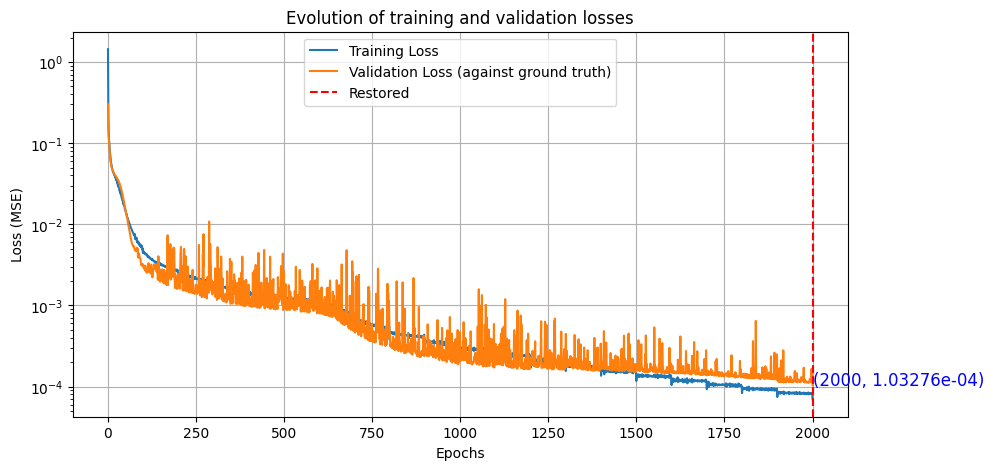

Model: "pinn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv0 (Conv1D)                  │ (None, 10, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv1D)                  │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,957 (304.52 KB)

 Trainable params: 25,985 (101.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,972 (203.02 KB)

In [ ]:
#globals
#------
n_features = X.shape[1]
n_hid_layers = 3
filters = 64
kernel_size = 3
act = "tanh"
epochs = 2000
patience = 100
start_from_epoch = 200
schedule_tg = 100
metrics = ["mse"]
opt = Adam(learning_rate=1e-4, weight_decay=1e-2)
alpha = 0.5 #physics weight = 1-alpha
#don't think boundary loss is needed when providing the states directly,
# as they serve as x0 -> a hard constraint for initial condition at each time step
true_phy_params = { #copied from above
    #*constant
    "g": PHYSICS_PARAMS["g"],
    "m": PHYSICS_PARAMS["m"], #kg toyota prius 2001 curb weight (fixed weight)
    # https://en.wikipedia.org/wiki/Automobile_drag_coefficient
    "Af": PHYSICS_PARAMS["Af"], # car cross sectional area
    "Cd": PHYSICS_PARAMS["Cd"], #toyota prius 2001
    #*variable
    #rolling resistance:
    "c0": PHYSICS_PARAMS["c0"],
    "c1": PHYSICS_PARAMS["c1"],
    "p": PHYSICS_PARAMS["p"], #average air density
    "road_grade": PHYSICS_PARAMS["road_grade"]
}
#train_params = {"m": 1000, "Af": 2.5, "Cd": 0.2} #if joint training provide initial values
train_params = {}
#------

pinn_model = PinnModel(true_phy_params, train_params, n_hid_layers, kernel_size=kernel_size, filters=filters, act=act) #default kernel size = 3
#Custom PINN loss
loss = CombinedLoss(model=pinn_model, X_c=X_c, scaler_X=scaler_X, scaler_Y=scaler_Y, alpha=alpha, window_size=window_size)
pinn_model.build(input_shape=(None, window_size, n_features)) #none -> batch dim
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)

def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath=f'models/pinn_{model_name}.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

class CustomWeightLog(Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        if len(self.model.train_params) > 0: #if joint training
          for key, value in self.model.params.items():
              logs[key] = value
    def on_train_end(self, logs=None):
        print(f"Custom trainable weights converged to:")
        for key in self.model.train_params: #in trainable params list
            value = self.model.params[key]
            true_value = self.model.true_params[key]
            percentage = abs((value-true_value)/true_value)*100
            print(f"{key} = {value.numpy():.5e}, true value = {true_value} ({percentage:.3f}% difference)")

custom_weight_logger = CustomWeightLog()

callbacks = [early_stopping, lr_scheduler, checkpoint, custom_weight_logger]
#callbacks = [lr_scheduler, checkpoint, custom_weight_logger] #removed ES

#training
history_pinn_fwd = pinn_model.fit(x=ds_train, validation_data=ds_val, epochs=epochs,
                                  callbacks=callbacks)
loss_plot(history_pinn_fwd.history, start_from_epoch)
pinn_model.summary()


# PUNN vs PINN (TESTING)

In [34]:
test_traj = "us06col"
scaler_X = joblib.load(f"models/scalers/scalerX_{model_name}.save")
scaler_Y = joblib.load(f"models/scalers/scalerY_{model_name}.save")
df_test = pd.read_csv("data/driving_cycles/CACC_" + test_traj + ".csv")

X_test = df_test[["t", "fv0_u", "fv0_v_noise", "d_fv0_lv_noise", "d*_fv0_lv", "lv_v_noise"]].to_numpy()
padding = np.repeat(X_test[0:1, :], window_size-1, axis=0) #need to pad features (like in a real application until the buffer is filled)
X_test = np.vstack([padding, X_test])
ds_X_test = tf.data.Dataset.from_tensor_slices(X_test)
ds_X_test = ds_X_test.window(size=window_size, shift=1, drop_remainder=True).flat_map(lambda window:window.batch(window_size))
true_data = df_test[["fv0_a", "fv0_v", "fv0_x"]].to_numpy()

#no shuffling this time 
#passing here true_data just to reuse this function:
ds_test_norm = ds_X_test.map(lambda window_x: tf_scale_window(scaler_X, scaler_Y, window_x, true_data[0,:], window_size, n_features))
ds_test_norm = ds_X_test.batch(1).prefetch(buffer_size=tf.data.AUTOTUNE) #test sequentially -> batch=1


256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 5.4874e-05
Testing trajectory (us06col) statistics: 
PUNN:
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


c:\Users\Jose\Desktop\Escolinha\Tese\PINN-control-platooning\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


----
MSE/RMSE for acceleration: 3.36919e+00, 1.83554e+00
MSE/RMSE for velocity: 3.14297e+05, 5.60622e+02
MSE/RMSE for position: 1.39780e+10, 1.18229e+05


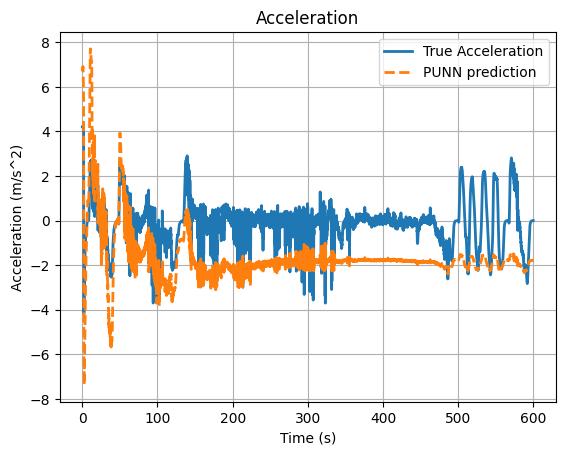

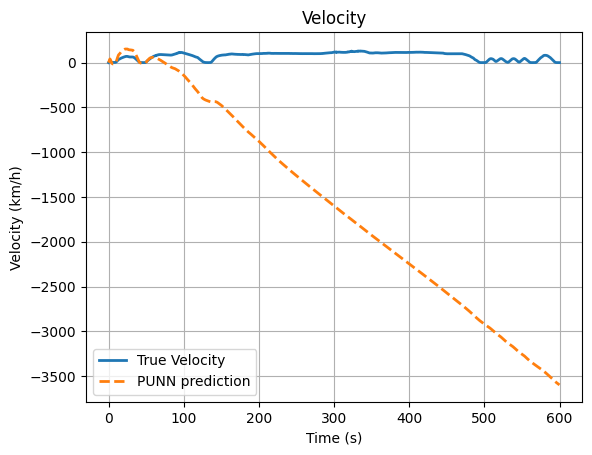

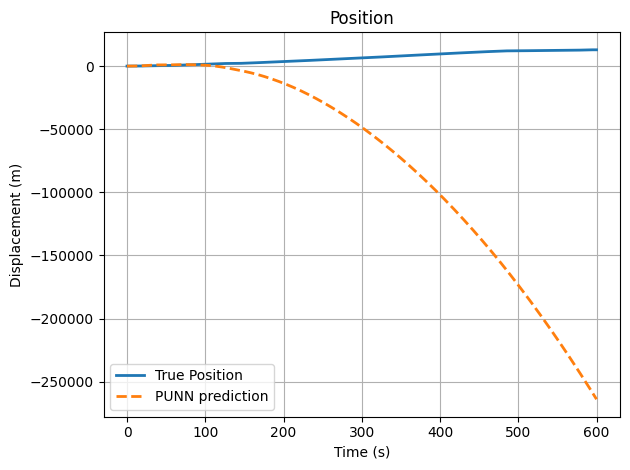

In [ ]:
punn_model = load_model(f"models/punn_{model_name}.keras", compile=True)
#punn_model.evaluate(ds_val) double check validation loss
#Load custom pinn model
#custom_objects = {"PinnModel": PinnModel}#, "train_params": train_params, "true_phy_params": true_phy_params}
#pinn_model = load_model(f"models/pinn_{model_name}.keras", custom_objects=custom_objects, compile=False)
#print("Converged phy values:", pinn_model.params)

print("Testing trajectory (" + test_traj + ") statistics: ")
print("PUNN:")
punn_test_norm = punn_model.predict(ds_test_norm) #scaled
""" print("PUNN:")
pinn_test_traj_eval = pinn_model.predict(ds_test) """
print("----")
punn_pred_avp = evaluate_results(punn_test_norm, true_data, dt, scaler_Y)

comparison_plot(dt, true_data=true_data, meas_data=None,
    pred_data=[(punn_pred_avp, "PUNN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN vs PINN for trajectory " + test_traj
)

# Convert to ONNX

In [ ]:
custom_objects = {"PinnModel": PinnModel}
model = load_model(f"models/pinn_{model_name}.keras", custom_objects=custom_objects, compile=False)
input_shape = (1, n_features)
print("***Loading model...", f"Input shape = {input_shape}")

model_input_signature = [
    tf.TensorSpec(shape=input_shape, dtype=tf.float32, name='input'),
]
model.output_names = ['output'] #had to add this to prevent error. I think its because model hasnt been called yet
onnx_model, _ = tf2onnx.convert.from_keras(model,
    output_path=f'models/onnx/pinn{model_name}.onnx',
    input_signature=model_input_signature,
)

***Loading model... Input shape = (1, 6)
